In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182 (from 1)
Receiving objects: 100% (254/254), 94.70 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22739 sha256=55bc8909336c0f23841e5c653fa44c8e14ab07a31f5499be0e275e9183d9cdc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-twee97we/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [4]:
!ls -lsrt sample_data

total 55504
    4 -rwxr-xr-x 1 root root      962 Jan  1  2000 README.md
    4 -rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
35668 -rw-r--r-- 1 root root 36523880 Dec 19 14:20 mnist_train_small.csv
 1668 -rw-r--r-- 1 root root  1706430 Dec 19 14:20 california_housing_train.csv
  296 -rw-r--r-- 1 root root   301141 Dec 19 14:20 california_housing_test.csv
17864 -rw-r--r-- 1 root root 18289443 Dec 19 14:20 mnist_test.csv


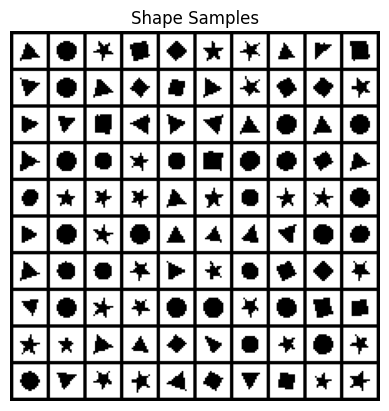

In [8]:
visualize_q2a_data(1)

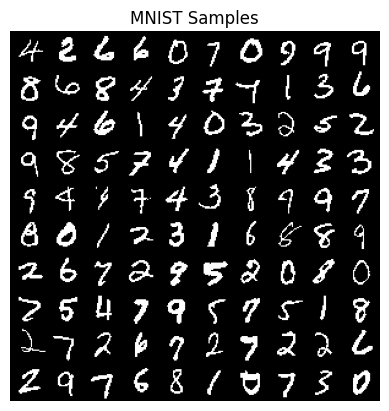

In [9]:
visualize_q2a_data(2)

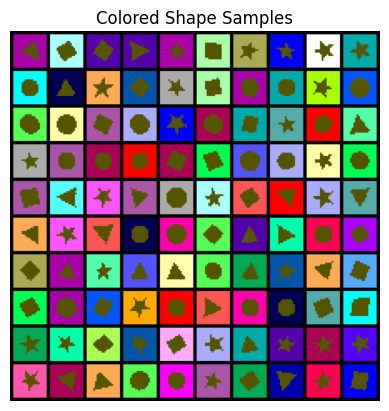

In [10]:
visualize_q2b_data(1)

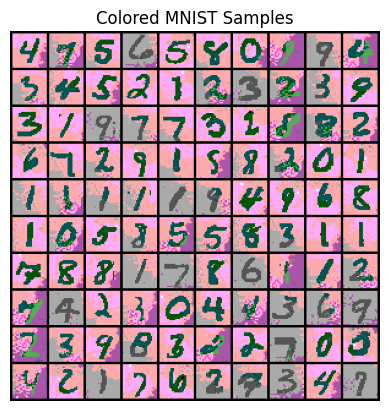

In [11]:
visualize_q2b_data(2)

# iGPT

## Autoregressive Transformer on Shapes and MNIST
Implement a simple Autoregressive Transformer to model binary MNIST and shapes images.

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.optim import Adam

class Config:
    def __init__(self, vocab_size, d_model, num_heads,
                 num_layers, max_seq_len, p_dropout):
      self.vocab_size = vocab_size
      self.emb_dim = d_model
      self.n_head = num_heads
      self.n_layers = num_layers
      self.max_seq_len = max_seq_len
      self.p_dropout = p_dropout


class CausalSelfAttn(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_head = cfg.n_head
        self.emb_dim = cfg.emb_dim
        self.p_dropout = cfg.p_dropout
        # k,q,v, projections
        self.attn_proj = nn.Linear(self.emb_dim, 3 * self.emb_dim)
        # output project.
        self.op_proj = nn.Linear(self.emb_dim, self.emb_dim)
        # dropout
        self.attn_dropout = nn.Dropout(self.p_dropout)
        self.residual_dropout = nn.Dropout(self.p_dropout)


    def create_causal_mask(self, batch_size, num_heads, seq_len, device):
      mask = torch.tril(torch.ones(seq_len, seq_len, device=device)).bool()
      return mask.unsqueeze(0).unsqueeze(0).expand(
          batch_size, num_heads, seq_len, seq_len)


    def forward(self, x):
      # x: shape => B x seq_len x embedding
      B, S, D = x.size()
      qkv = self.attn_proj(x)
      q, k, v = qkv.split(self.emb_dim, dim=2)

      q = q.view(B, S, self.n_head, D // self.n_head).transpose(1,2)
      k = k.view(B, S, self.n_head, D // self.n_head).transpose(1,2)
      v = v.view(B, S, self.n_head, D // self.n_head).transpose(1,2)
      # causal self attention
      attn = (q @ k.transpose(2, 3)) * (1.0 / math.sqrt(k.size(-1)))
      attn = attn.masked_fill(self.create_causal_mask(
          B,self.n_head,S, device=x.device) == 0, float("-inf"))
      attn = F.softmax(attn, dim=-1)
      attn = self.attn_dropout(attn)
      op = attn @ v
      op = op.transpose(1,2).contiguous().view(B, S, D)
      return self.residual_dropout(self.op_proj(op))

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln_1 = nn.LayerNorm(cfg.emb_dim)
        self.attn = CausalSelfAttn(cfg)
        self.ln_2 = nn.LayerNorm(cfg.emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(cfg.emb_dim, 4 * cfg.emb_dim),
            nn.GELU(),
            nn.Linear(4 * cfg.emb_dim, cfg.emb_dim),
            nn.Dropout(cfg.p_dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x




class iGPT(nn.Module):
    """
    A small GPT-like (autoregressive) Transformer.
    """
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2,
                 max_seq_len=785, p_dropout=0.1):
        super().__init__()
        self.cfg = Config(
            vocab_size, d_model, num_heads,
            num_layers, max_seq_len, p_dropout
        )
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        self.blocks = nn.Sequential(*[TransformerBlock(self.cfg) for _ in range(num_layers)])
        self.final_ln = nn.LayerNorm(d_model)
        self.final_mlp = nn.Linear(d_model, vocab_size, bias=False)
        self.final_mlp.weight.data.zero_()
        self.apply(self.init_w)


    def init_w(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)



    def forward(self, idx):
        """
        idx: (batch_size, seq_len) of token IDs
        Returns:
          logits: (batch_size, seq_len, vocab_size)
        """
        # print(idx.device)
        B, S = idx.size()
        token_emb = self.tok_emb(idx)
        pos = torch.arange(0, S, dtype=torch.long,
                           device=idx.device).unsqueeze(0)
        pos_emb = self.pos_emb(pos)

        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.final_ln(x)
        x = self.final_mlp(x)
        return x


    @torch.no_grad()
    def generate(self, x, seq_len, temp=1.0, do_sample=False, top_k=None):
        for _ in range(seq_len):
            logits = self(x)
            logits = logits[:,-1,:] / temp
            if top_k is not None:
                vals, _ = torch.topk(logits, top_k)
                logits[logits < vals[:, [-1]]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            if do_sample:
              next_token = torch.multinomial(probs, num_samples=1)
            else:
              _, next_token = torch.topk(probs,k=1,dim=-1)
            x = torch.cat([x, next_token], dim=1)
        return x




In [3]:
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, LinearLR, CosineAnnealingLR
from torch.optim import Adam
from sklearn.cluster import KMeans


class BinaryImgDataset(Dataset):
    def __init__(self, data, image_shape):
        self.data = data
        self.image_shape = image_shape

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        H,W,C = self.image_shape
        image = self.data[idx].reshape(-1)
        sequence = np.insert(image, 0, 2)
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)



def igpt(train_data, test_data, image_shape, dset_id):
    """
    train_data: (n_train, H, W, 1) np.uint8 images in {0, 1}
    test_data: (n_test, H, W, 1)  np.uint8 images in {0, 1}
    image_shape: (H, W, 1)
    dset_id: dataset identifier

    Returns:
      train_losses: (# of training iterations,) np.array
      test_losses:  (# of epochs + 1,) np.array
      samples:      (100, H, W, 1) np.array
    """

    ###################################################################
    #                         1. DATA PREP                            #
    ###################################################################

    H, W, _ = image_shape
    seq_len = H * W + 1  # <bos> + 1D



    train_ds = BinaryImgDataset(train_data, image_shape)
    test_ds = BinaryImgDataset(test_data, image_shape)

    TRAIN_BS = 64 if dset_id == 1 else 128
    TEST_BS = 64
    train_loader = DataLoader(train_ds,
                              # sampler=torch.utils.data.RandomSampler(train_ds, replacement=True, num_samples=int(1e10)),
                              # pin_memory=True,
                              # num_workers=10,
                              batch_size=TRAIN_BS, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=TEST_BS)



    ###################################################################
    #                     2. MODEL INIT                               #
    ###################################################################
    # TODO create the model and any additional state e.g. optimizers
    vocab_size = 3
    d_model = 128
    num_heads = 4
    num_layers = 2
    p_dropout = 0.1
    num_warmup_steps = 1000
    num_epochs = 15 if dset_id == 1 else 7
    max_seq_len = seq_len

    model = iGPT(vocab_size, d_model, num_heads, num_layers, max_seq_len, p_dropout)
    optimizer = Adam(model.parameters(), lr = 0.001)
    num_training_steps = num_epochs * len(train_loader)
    warmup_scheduler = LinearLR(optimizer, start_factor=0.001, total_iters=num_warmup_steps)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_training_steps - num_warmup_steps)
    lr_scheduler = SequentialLR(
        optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[num_warmup_steps]
    )

    criterion = nn.CrossEntropyLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)



    train_losses = []
    test_losses = []

    ###################################################################
    #                 3. EVALUATION (TEST LOSS) FN                    #
    ###################################################################
    def evaluate_loss(data_loader):
        # TODO IMPLEMENT EVAL LOOP
        model.eval()
        total_loss = 0
        with torch.no_grad():
          for x,y in data_loader:
              x = x.to(device)
              y = y.to(device)
              logits = model(x)
              loss = criterion(logits.view(-1, vocab_size), y.view(-1))
              total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(data_loader.dataset)
        return avg_loss

    # Evaluate initial test loss
    test_nll = evaluate_loss(test_loader)
    test_losses.append(test_nll)
    print(f"Epoch 0/{num_epochs} | Test NLL: {test_nll:.4f}")

    ###################################################################
    #                   4. TRAINING LOOP                              #
    ###################################################################
    global_step = 0
    print(f"Starting Training with Epochs:{num_epochs}, iters_per_epoch: {len(train_loader.dataset) // TRAIN_BS}")
    for epoch_id, epoch in enumerate(range(num_epochs)):
        # TODO IMPLEMENT TRAIN LOOP
        model.train()
        for x,y in train_loader:
          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()
          logits=model(x)
          loss = criterion(logits.view(-1, vocab_size), y.view(-1))
          loss.backward()
          optimizer.step()
          lr_scheduler.step()

          train_losses.append(loss.item())
          global_step += 1
        print(f"Finished epoch:{epoch_id}, global_step: {global_step} ")
        # Evaluate after each epoch
        test_nll = evaluate_loss(test_loader)
        test_losses.append(test_nll)
        print(f"Epoch {epoch+1}/{num_epochs} | Test NLL: {test_nll:.4f} | LR: {lr_scheduler.get_last_lr()[0]:.6f}")

    ###################################################################
    #                     5. SAMPLING / GENERATION                    #
    ###################################################################
    model.eval()
    samples_list = []
    sample_test_loader = DataLoader(test_ds, batch_size=1)
    sample_loader_iter = iter(sample_test_loader)
    with torch.no_grad():
        for _ in range(100):
            # TODO
            x, _ = next(sample_loader_iter)
            context = x[:, :(H*W)//2]
            context = context.to(device)
            gen_seq = model.generate(context, max_seq_len - context.size()[-1], temp=1.0,
                                     do_sample=True)
            sample = gen_seq.squeeze(0)[1:].reshape(H,W,1).cpu().numpy()
            samples_list.append(sample)

    return train_losses, test_losses, np.array(samples_list, dtype=np.int64)

In [41]:
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, LinearLR, CosineAnnealingLR
from torch.optim import Adam
from sklearn.cluster import KMeans

def compute_centroids(data, image_shape, n_clusters):
    H,W,C = image_shape
    pixels = data.reshape(-1,C)
    kmeans= KMeans(n_clusters=n_clusters, random_state=0).fit(pixels)
    return kmeans.cluster_centers_


class ColorImageDataset(Dataset):
    def __init__(self, data, image_shape, cluster_centers, bos_token):
        self.data = data  # (N, H, W, C)
        self.image_shape = image_shape
        self.bos_token = bos_token
        self.cluster_centers = cluster_centers


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        H, W, C = self.image_shape
        image = self.data[idx]
        image_tokens = self.quantize_image(image)
        assert self.bos_token not in image_tokens

        sequence = np.insert(image_tokens.reshape(-1), 0, self.bos_token)  # (H*W + 1)
        input_seq = sequence[:-1]
        target_seq = sequence[1:]

        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(
            target_seq, dtype=torch.long
        )

    def quantize_image(self, image):
        H, W, C = image.shape
        pixels = image.reshape(-1, C)
        distances = np.linalg.norm(pixels[:, np.newaxis, :] - self.cluster_centers, axis=2)
        tokens = np.argmin(distances, axis=1)
        return tokens.reshape(H, W)

    def dequantize_image(self, tokens):
        H, W = tokens.shape
        tokens = tokens.reshape(-1)
        pixels = self.cluster_centers[tokens]
        return pixels.reshape(H, W, -1)


def igpt_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: (n_train, H, W, 1) np.uint8 images in {0, 1}
    test_data: (n_test, H, W, 1)  np.uint8 images in {0, 1}
    image_shape: (H, W, 1)
    dset_id: dataset identifier

    Returns:
      train_losses: (# of training iterations,) np.array
      test_losses:  (# of epochs + 1,) np.array
      samples:      (100, H, W, 1) np.array
    """
    ###################################################################
    #                         1. DATA PREP                            #
    ###################################################################
    H, W, _ = image_shape
    seq_len = H * W + 1  # <bos> + 1D
    n_clusters = 32
    centers = compute_centroids(train_data, image_shape, n_clusters=n_clusters)


    train_ds = ColorImageDataset(train_data, image_shape, centers, n_clusters)
    test_ds = ColorImageDataset(test_data, image_shape, centers, n_clusters)

    TRAIN_BS =64
    TEST_BS = 64
    train_loader = DataLoader(train_ds,
                              # sampler=torch.utils.data.RandomSampler(train_ds, replacement=True, num_samples=int(1e10)),
                              # pin_memory=True,
                              # num_workers=10,
                              batch_size=TRAIN_BS, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=TEST_BS)



    ###################################################################
    #                     2. MODEL INIT                               #
    ###################################################################
    # TODO create the model and any additional state e.g. optimizers
    vocab_size = n_clusters + 1
    d_model = 128
    num_heads = 4
    num_layers = 2
    p_dropout = 0.1
    num_warmup_steps = 1000
    num_epochs = 20


    max_seq_len = seq_len
    model = iGPT(vocab_size, d_model, num_heads, num_layers, max_seq_len, p_dropout)
    optimizer = Adam(model.parameters(), lr = 1e-3)
    num_training_steps = num_epochs * len(train_loader)
    warmup_scheduler = LinearLR(optimizer, start_factor=1e-3, total_iters=num_warmup_steps)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_training_steps - num_warmup_steps)
    lr_scheduler = SequentialLR(
        optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[num_warmup_steps]
    )

    criterion = nn.CrossEntropyLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)



    train_losses = []
    test_losses = []

    ###################################################################
    #                 3. EVALUATION (TEST LOSS) FN                    #
    ###################################################################
    def evaluate_loss(data_loader):
        # TODO IMPLEMENT EVAL LOOP
        model.eval()
        total_loss = 0
        with torch.no_grad():
          for x,y in data_loader:
              x = x.to(device)
              y = y.to(device)
              logits = model(x)
              loss = criterion(logits.view(-1, vocab_size), y.view(-1))
              total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(data_loader.dataset)
        return avg_loss

    # Evaluate initial test loss
    test_nll = evaluate_loss(test_loader)
    test_losses.append(test_nll)
    print(f"Epoch 0/{num_epochs} | Test NLL: {test_nll:.4f}")

    ###################################################################
    #                   4. TRAINING LOOP                              #
    ###################################################################
    global_step = 0
    print(f"Starting Training with Epochs:{num_epochs}, iters_per_epoch: {len(train_loader.dataset) // TRAIN_BS}")
    for epoch_id, epoch in enumerate(range(num_epochs)):
        # TODO IMPLEMENT TRAIN LOOP
        model.train()
        for x,y in train_loader:
          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()
          logits=model(x)
          loss = criterion(logits.view(-1, vocab_size), y.view(-1))
          loss.backward()
          optimizer.step()
          lr_scheduler.step()

          train_losses.append(loss.item())
          global_step += 1
        print(f"Finished epoch:{epoch_id}, global_step: {global_step} ")
        # Evaluate after each epoch
        test_nll = evaluate_loss(test_loader)
        test_losses.append(test_nll)

        print(f"Epoch {epoch+1}/{num_epochs} | Test NLL: {test_nll:.4f} | LR: {lr_scheduler.get_last_lr()[0]:.6f}")

    ###################################################################
    #                     5. SAMPLING / GENERATION                    #
    ###################################################################
    model.eval()
    samples_list = []
    sample_test_loader = DataLoader(test_ds, batch_size=1)
    sample_loader_iter = iter(sample_test_loader)
    with torch.no_grad():
        for _ in range(100):
            # TODO
            x, _ = next(sample_loader_iter)
            context = x[:, :(H*W)//2]
            context = context.to(device)
            gen_seq = model.generate(context, max_seq_len - context.size()[-1], temp=1.0,
                                     do_sample=True)
            sample = gen_seq.squeeze(0)[1:].reshape(-1).cpu().numpy()
            # dequantize
            pixels = centers[sample]
            samples_list.append(pixels.reshape(H,W,-1))

    return train_losses, test_losses, np.array(samples_list, dtype=np.int64)


### Results

Once you've implemented `igpt`, execute the cells below to visualize and save your results

Using device: cuda
Epoch 0/15 | Test NLL: 1.0762
Starting Training with Epochs:15, iters_per_epoch: 163
Finished epoch:0, global_step: 164 
Epoch 1/15 | Test NLL: 0.1278 | LR: 0.000165
Finished epoch:1, global_step: 328 
Epoch 2/15 | Test NLL: 0.0963 | LR: 0.000329
Finished epoch:2, global_step: 492 
Epoch 3/15 | Test NLL: 0.0841 | LR: 0.000493
Finished epoch:3, global_step: 656 
Epoch 4/15 | Test NLL: 0.0661 | LR: 0.000656
Finished epoch:4, global_step: 820 
Epoch 5/15 | Test NLL: 0.0565 | LR: 0.000820
Finished epoch:5, global_step: 984 
Epoch 6/15 | Test NLL: 0.0501 | LR: 0.000984


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Finished epoch:6, global_step: 1148 
Epoch 7/15 | Test NLL: 0.0465 | LR: 0.000975
Finished epoch:7, global_step: 1312 
Epoch 8/15 | Test NLL: 0.0447 | LR: 0.000891
Finished epoch:8, global_step: 1476 
Epoch 9/15 | Test NLL: 0.0439 | LR: 0.000760
Finished epoch:9, global_step: 1640 
Epoch 10/15 | Test NLL: 0.0418 | LR: 0.000596
Finished epoch:10, global_step: 1804 
Epoch 11/15 | Test NLL: 0.0404 | LR: 0.000421
Finished epoch:11, global_step: 1968 
Epoch 12/15 | Test NLL: 0.0393 | LR: 0.000255
Finished epoch:12, global_step: 2132 
Epoch 13/15 | Test NLL: 0.0387 | LR: 0.000119
Finished epoch:13, global_step: 2296 
Epoch 14/15 | Test NLL: 0.0383 | LR: 0.000031
Finished epoch:14, global_step: 2460 
Epoch 15/15 | Test NLL: 0.0382 | LR: 0.000000
Final Test Loss: 0.0382


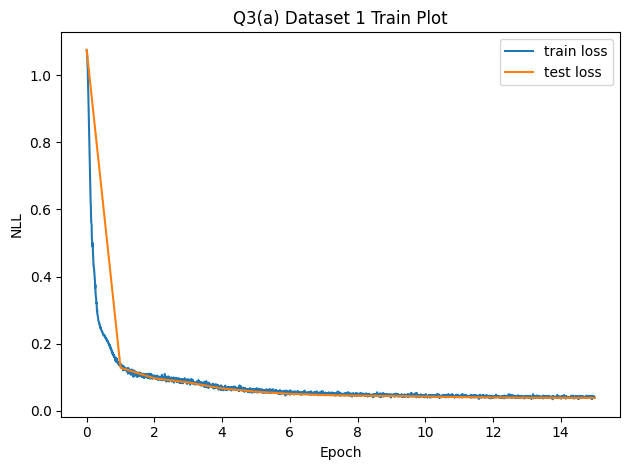

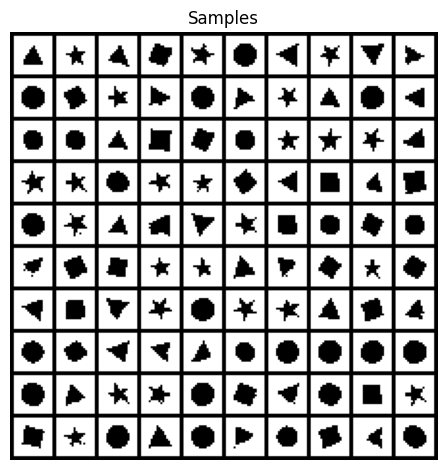

In [37]:
q3ab_save_results(1, 'a', igpt)

Using device: cuda
Epoch 0/7 | Test NLL: 1.1887
Starting Training with Epochs:7, iters_per_epoch: 468
Finished epoch:0, global_step: 469 
Epoch 1/7 | Test NLL: 0.1700 | LR: 0.000470
Finished epoch:1, global_step: 938 
Epoch 2/7 | Test NLL: 0.1017 | LR: 0.000938


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Finished epoch:2, global_step: 1407 
Epoch 3/7 | Test NLL: 0.0898 | LR: 0.000924
Finished epoch:3, global_step: 1876 
Epoch 4/7 | Test NLL: 0.0838 | LR: 0.000679
Finished epoch:4, global_step: 2345 
Epoch 5/7 | Test NLL: 0.0813 | LR: 0.000362
Finished epoch:5, global_step: 2814 
Epoch 6/7 | Test NLL: 0.0801 | LR: 0.000101
Finished epoch:6, global_step: 3283 
Epoch 7/7 | Test NLL: 0.0798 | LR: 0.000000
Final Test Loss: 0.0798


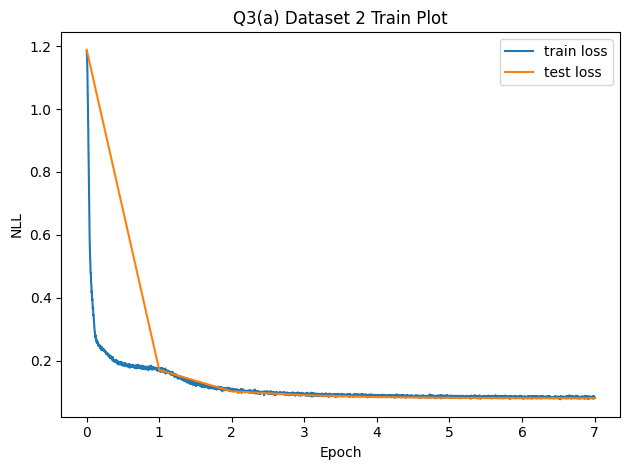

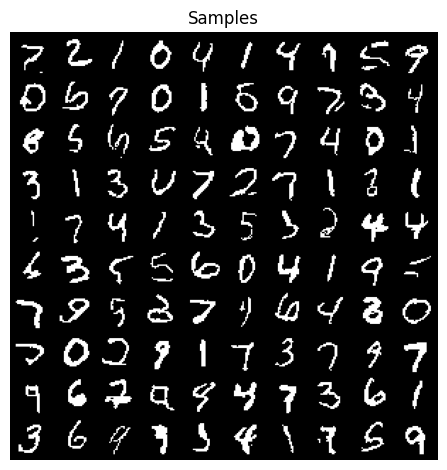

In [4]:
q3ab_save_results(2, 'a', igpt)

Using device: cuda
Epoch 0/20 | Test NLL: 3.4331
Starting Training with Epochs:20, iters_per_epoch: 163
Finished epoch:0, global_step: 164 
Epoch 1/20 | Test NLL: 0.7142 | LR: 0.000165
Finished epoch:1, global_step: 328 
Epoch 2/20 | Test NLL: 0.2010 | LR: 0.000329
Finished epoch:2, global_step: 492 
Epoch 3/20 | Test NLL: 0.1285 | LR: 0.000493
Finished epoch:3, global_step: 656 
Epoch 4/20 | Test NLL: 0.1002 | LR: 0.000656
Finished epoch:4, global_step: 820 
Epoch 5/20 | Test NLL: 0.0850 | LR: 0.000820
Finished epoch:5, global_step: 984 
Epoch 6/20 | Test NLL: 0.0751 | LR: 0.000984


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Finished epoch:6, global_step: 1148 
Epoch 7/20 | Test NLL: 0.0695 | LR: 0.000990
Finished epoch:7, global_step: 1312 
Epoch 8/20 | Test NLL: 0.0657 | LR: 0.000955
Finished epoch:8, global_step: 1476 
Epoch 9/20 | Test NLL: 0.0634 | LR: 0.000896
Finished epoch:9, global_step: 1640 
Epoch 10/20 | Test NLL: 0.0610 | LR: 0.000818
Finished epoch:10, global_step: 1804 
Epoch 11/20 | Test NLL: 0.0605 | LR: 0.000723
Finished epoch:11, global_step: 1968 
Epoch 12/20 | Test NLL: 0.0592 | LR: 0.000617
Finished epoch:12, global_step: 2132 
Epoch 13/20 | Test NLL: 0.0570 | LR: 0.000506
Finished epoch:13, global_step: 2296 
Epoch 14/20 | Test NLL: 0.0550 | LR: 0.000393
Finished epoch:14, global_step: 2460 
Epoch 15/20 | Test NLL: 0.0547 | LR: 0.000287
Finished epoch:15, global_step: 2624 
Epoch 16/20 | Test NLL: 0.0538 | LR: 0.000191
Finished epoch:16, global_step: 2788 
Epoch 17/20 | Test NLL: 0.0531 | LR: 0.000111
Finished epoch:17, global_step: 2952 
Epoch 18/20 | Test NLL: 0.0527 | LR: 0.000050

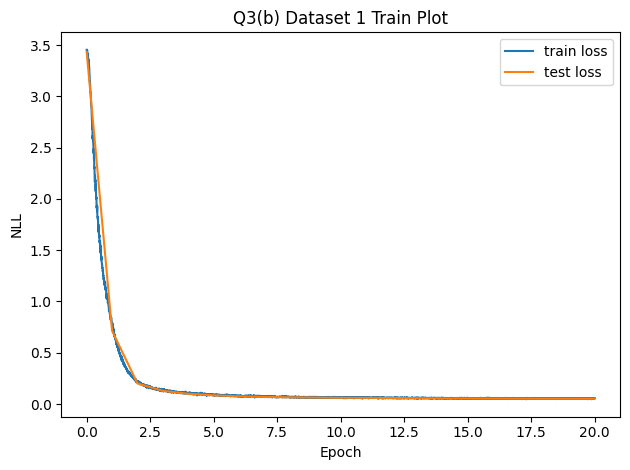

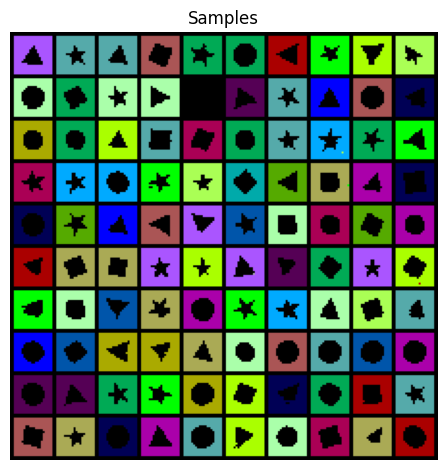

In [42]:
q3ab_save_results(1, 'b', igpt_c)

In [ ]:
# colored MNIST
# q3ab_save_results(1, 'b', q3_b)
# q3ab_save_results(2, 'b', q3_b)